# Community Assortativity Coefficient

*November 3 2021*  

In the second practice session, we implement the community assortativity coefficient, which allows us to compare the optimal partition quality (i.e. modularity) to the maximally possible modularity in a given network.

In [1]:
import pathpy as pp
import numpy as np

import sqlite3
from tqdm import tqdm

import random
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

In [2]:
def Q(network, C):
    m = network.number_of_edges()
    n = network.number_of_nodes()

    A = network.adjacency_matrix().todense()

    q = 0.0
    for v in network.nodes.uids:
        for w in network.nodes.uids:
            if C[v] == C[w]:
                q += A[network.nodes.index[v], network.nodes.index[w]] - network.degrees()[v] * network.degrees()[w]/(2*m)
    q /= 2*m
    return q

def Q_merge(network, A, D, n, m, C, merge=set()):
    q = 0.0
    for v in network.nodes.uids:
        for w in network.nodes.uids:
            if C[v] == C[w] or (C[v] in merge and C[w] in merge):
                q += A[network.nodes.index[v], network.nodes.index[w]] - D[v]*D[w]/(2*m)
    q /= 2*m
    return q

def find_communities(network, iterations=100):
    # start with each node being in a separate cluster

    A = network.adjacency_matrix(weighted=False)
    D = network.degrees()
    n = network.number_of_nodes()
    m = network.number_of_edges()

    C = {}
    nums = np.zeros(iterations)
    num_communities = n
    community_to_nodes = {}
    c = 0
    for v in network.nodes.uids:
        C[v] = c
        community_to_nodes[c] = set([v])
        c += 1
    q = Q_merge(network, A, D, n, m, C)
    
    for i in tqdm(range(iterations), desc='maximising modularity'):

        nums[i] = num_communities

        # randomly choose two communities
        x, y = random.sample(community_to_nodes.keys(), 2)

        # check Q of merged communities
        q_new = Q_merge(network, A, D, n, m, C, merge=set([x, y]))

        if q_new > q:
            # merge communities
            for v in community_to_nodes[x]:
                C[v] = y
            community_to_nodes[y] = community_to_nodes[y].union(community_to_nodes[x])
            q = q_new
            num_communities -=1
            del community_to_nodes[x]
        
    return C, q, nums

colors = sns.color_palette("Set1", 200)

In [3]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.plot()

## Community assortativity coefficient

In the toy example in the lecture, we found that the modularity of the network is well below the theoretical maximum of one. Nevertheless, there is a clearly visible and strong community structure consisting of two clusters of nodes that are connected by a single link. Using the definition from theory lecture L02 we can implement a function that computes the theoretical maximum modularity $Q_{max}$ for a given network and partition:

In [4]:
def Qmax(network, C):
    m = network.number_of_edges()
    qmax = 2*m
    for v in network.nodes.uids:
        for w in network.nodes.uids:
            if C[v] == C[w]:
                qmax -= network.degrees()[v]*network.degrees()[w]/(2*m)
    
    return qmax/(2*m)

We use this to calculate the maximum possible partition quality for the toy example and as well as the *community assortativity coefficient* defined in lecture L03:

In [5]:
C, q_opt, nums = find_communities(n)
print('Q_opt =', q_opt)

q_max = Qmax(n, C)
print('Q_max =', q_max)

print("Community assortativity coefficient =", q_opt/q_max)

for v in n.nodes:
    v['color'] = colors[C[v.uid]]
n.plot()

maximising modularity: 100%|██████████| 100/100 [00:00<00:00, 140.25it/s]

Q_opt = 0.3641975308641976
Q_max = 0.47530864197530903
Community assortativity coefficient = 0.7662337662337657


In [6]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.add_edge('e', 'g')
n.plot()

In [7]:
C, q_opt, nums = find_communities(n)
print('Q_opt =', q_opt)

q_max = Qmax(n, C)
print('Q_max =', q_max)

print("Community assortativity coefficient =", q_opt/q_max)

for v in n.nodes:
    v['color'] = colors[C[v.uid]]
n.plot()

maximising modularity: 100%|██████████| 100/100 [00:00<00:00, 203.14it/s]

Q_opt = 0.44444444444444453
Q_max = 0.44444444444444486
Community assortativity coefficient = 0.9999999999999992


## Modularity-based Community Detection in Empirical networks

We conclude this weeks practice lecture by an application of modularity-based community detection to empirical networks. We limit ourselves to the undirected networks `highschool`, `physician`, and `lotr` in our database:

In [25]:
n_highschool = pp.io.sql.read_network('../data/networks.db', sql='SELECT source, target FROM "highschool"', directed=False)
n_physicians = pp.io.sql.read_network('../data/networks.db', sql='SELECT source, target FROM "physicians"', directed=False)
n_lotr = pp.io.sql.read_network('../data/networks.db', sql='SELECT source, target FROM "lotr"', directed=False)

[11-02 12:33:48: WARNING] 154 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.
[11-02 12:33:48: WARNING] 175 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.
[11-02 12:33:48: WARNING] 2015 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


We use `matplotlib` to plot the number of detected communities against the number of iterations performed by the optimisation algorithm in our implementation of the method `find_communities`. This can help us determine that the algorithm has converged:

maximising modularity: 100%|██████████| 2000/2000 [03:59<00:00,  8.37it/s]


Number of communities = 3
Modularity = 0.5667731866825081
Community assortativity coefficient = 0.8756865371734565


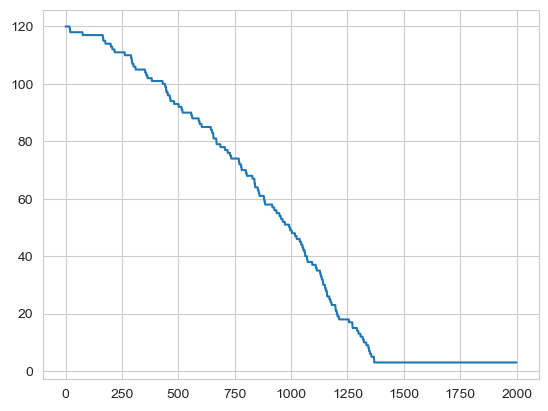

In [26]:
C, q_opt, nums = find_communities(n_highschool, iterations=2000)
q_max = Qmax(n_highschool, C)

print("Number of communities =", len(set(C.values())))
print("Modularity =", q_opt)
print("Community assortativity coefficient =", q_opt/q_max)
plt.clf()
plt.plot(nums)
plt.show()

We can now visualise the detected communities:

In [27]:
C.values()

dict_values([93, 39, 39, 93, 93, 93, 93, 55, 93, 55, 39, 93, 93, 93, 39, 93, 39, 93, 93, 93, 39, 93, 39, 39, 55, 55, 93, 39, 93, 93, 93, 39, 39, 39, 39, 93, 39, 39, 55, 39, 39, 39, 39, 39, 55, 55, 55, 39, 93, 39, 39, 93, 39, 93, 39, 55, 93, 93, 39, 39, 93, 39, 39, 39, 39, 93, 55, 93, 55, 93, 93, 93, 55, 93, 39, 55, 39, 93, 93, 39, 39, 93, 93, 39, 55, 39, 55, 55, 93, 93, 39, 93, 55, 93, 55, 39, 93, 55, 93, 39, 39, 93, 93, 55, 39, 93, 55, 93, 39, 55, 39, 39, 39, 55, 93, 39, 55, 39, 55, 93])

In [28]:
colors = sns.color_palette("Set1", 120)
n_highschool.plot(node_color={v: colors[C[v]] for v in n_highschool.nodes.uids})

We finally repeat our analysis for the physicians and the lotr networks:

maximising modularity: 100%|██████████| 3000/3000 [01:38<00:00, 30.34it/s]


Number of communities = 132
Modularity = 0.1312409836969982
Community assortativity coefficient = 0.13472434094628236


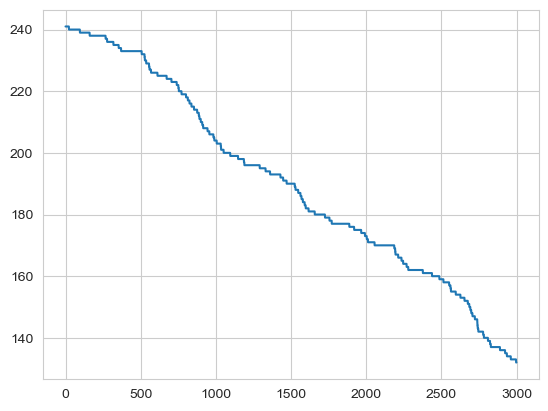

In [30]:
C, q_opt, nums = find_communities(n_physicians, iterations=3000)
q_max = Qmax(n_physicians, C)

print("Number of communities =", len(set(C.values())))
print("Modularity =", q_opt)
print("Community assortativity coefficient =", q_opt/q_max)
plt.clf()
plt.plot(nums)
plt.show()

In [33]:
colors = sns.color_palette("Set1", 300)
n_physicians.plot(node_color={v: colors[C[v]] for v in n_physicians.nodes.uids})

maximising modularity: 100%|██████████| 3000/3000 [08:13<00:00,  6.08it/s]


Number of communities = 6
Modularity = 0.2853869577764704
Community assortativity coefficient = 0.5354140704126892


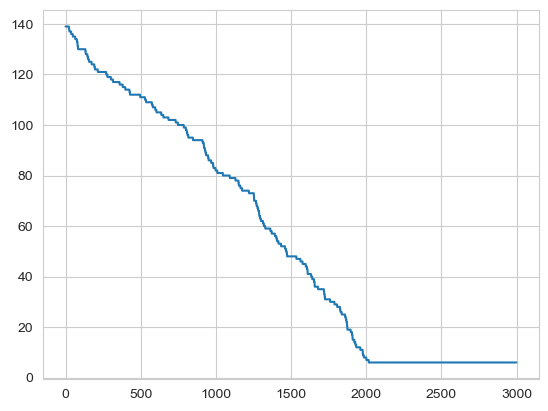

In [34]:
C, q_opt, nums = find_communities(n_lotr, iterations=3000)
q_max = Qmax(n_lotr, C)

print("Number of communities =", len(set(C.values())))
print("Modularity =", q_opt)
print("Community assortativity coefficient =", q_opt/q_max)
plt.clf()
plt.plot(nums)
plt.show()

In [35]:
n_lotr.plot(node_color={v: colors[C[v]] for v in n_lotr.nodes.uids})